In [1]:
import os, sys
sys.path.append("..")

from pathlib import Path
from tqdm import tqdm
from typing import List, Optional
from omegaconf import OmegaConf
import math, json, shutil
import numpy as np
import pyiqa
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Value
from PIL import Image, ImageDraw
from safetensors.torch import load_file, save_file
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import SiglipImageProcessor, SiglipVisionModel, SiglipVisionConfig
import lovely_tensors as lt
lt.monkey_patch()

from musubi_tuner.cache_latents import setup_parser_common, hv_setup_parser, preprocess_contents
from musubi_tuner.dataset.config_utils import BlueprintGenerator, ConfigSanitizer, load_user_config, generate_dataset_group_by_blueprint
from musubi_tuner.dataset.image_video_dataset import DatasetGroup, ImageDataset, ItemInfo, save_latent_cache_framepack, BucketSelector
from musubi_tuner.frame_pack.clip_vision import hf_clip_vision_encode
from musubi_tuner.frame_pack.framepack_utils import load_image_encoders, load_vae, FEATURE_EXTRACTOR_CONFIG, IMAGE_ENCODER_CONFIG
from musubi_tuner.frame_pack.hunyuan import vae_encode
from musubi_tuner.hunyuan_model.autoencoder_kl_causal_3d import AutoencoderKLCausal3D
from musubi_tuner.fpack_cache_latents import encode_and_save_batch_one_frame, append_section_idx_to_latent_cache_path
from musubi_tuner.hv_train_network import collator_class, load_prompts
from musubi_tuner.utils.bbox_utils import get_bbox_from_mask, get_mask_from_bboxes, draw_bboxes, get_facebbox_from_bbox, get_bbox_from_meta
from musubi_tuner.utils.preproc_utils import get_text_preproc, prepare_control_inputs_for_entity, preproc_mask, postproc_imgs

device = torch.device('cuda:0')

# mpath = Path('/groups/chenchen/patrick/OpenS2V-Nexus/datasets/')

Trying to import sageattention
Successfully imported sageattention
model_path is /u/ykwon4/models/musubi-tuner/src/practice/../musubi_tuner/ckpts/hr16/yolox-onnx/yolox_l.torchscript.pt
model_path is /u/ykwon4/models/musubi-tuner/src/practice/../musubi_tuner/ckpts/hr16/DWPose-TorchScript-BatchSize5/dw-ll_ucoco_384_bs5.torchscript.pt

DWPose: Using yolox_l.torchscript.pt for bbox detection and dw-ll_ucoco_384_bs5.torchscript.pt for pose estimation
DWPose: Caching TorchScript module yolox_l.torchscript.pt on ...
DWPose: Caching TorchScript module dw-ll_ucoco_384_bs5.torchscript.pt on ...


/u/ykwon4/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/u/ykwon4/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [8]:
df = pd.read_csv("/u/ykwon4/models/musubi-tuner/src/practice/test3_part4_v3_cache_topiq_scores.csv")
path1 = Path("/work/hdd/bffz/ykwon4/OpenS2V-Nexus/test3_part4_v3_cache")
path2 = Path("/work/hdd/bffz/ykwon4/OpenS2V-Nexus/test3_part4_v4_cache")
path2.mkdir(parents=True, exist_ok=True)

for name in df.loc[((df['topiq_score'] > 0.35) & (df['topiq_face_score'] > 0.4))].file:
    name = name.split("_step4")[0]
    files = list(path1.glob(f"{name}*.safetensors"))
    for file in files:
        shutil.copy(file, path2 / file.name)

In [13]:
# path1 = Path("/work/hdd/bffz/ykwon4/Subjects200K/subjects200k_cache")
path1 = Path("/work/hdd/bffz/ykwon4/Anime-Shooter/test_output_chara2_cache")
path2 = Path("/work/hdd/bffz/ykwon4/Anime-Shooter/test_output_chara2_cache_subset")
path2.mkdir(parents=True, exist_ok=True)
for file in sorted(list(path1.glob("*")))[:2000]:
    shutil.copy(file, path2 / file.name)

In [ ]:
# CUDA_VISIBLE_DEVICES=3, python fpack_cache_latents.py \
# --dataset_config "/home/ce407038/patrick/datasets/OpenS2V-Nexus/tmp_4.toml" \
# --vae "/home/ce407038/patrick/ComfyUI/models/vae/hunyuan-video-t2v-720p-vae.pt" \
# --image_encoder "/home/ce407038/patrick/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors" \
# --vae_chunk_size 32 --vae_spatial_tile_sample_min_size 128  \
# --skip_existing --keep_cache --one_frame --one_frame_no_2x --one_frame_no_4x

iqa_metric = pyiqa.create_metric('topiq_nr', device=device)
iqa_metric_face = pyiqa.create_metric('topiq_nr-face', device=device)

In [4]:
vae = load_vae("/projects/bffz/ykwon4/ComfyUI/models/vae/hunyuan-video-t2v-720p-vae.pt", 32, 128, device=device)
vae.to(device)

feature_extractor = SiglipImageProcessor(**FEATURE_EXTRACTOR_CONFIG)

config = SiglipVisionConfig(**IMAGE_ENCODER_CONFIG)
image_encoder = SiglipVisionModel._from_config(config, torch_dtype=torch.float16)
state_dict = load_file("/projects/bffz/ykwon4/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors")
image_encoder.load_state_dict(state_dict, strict=True, assign=True)
image_encoder.eval()

print("Model Loaded")

INFO:musubi_tuner.hunyuan_model.vae:Loading 3D VAE model (884-16c-hy) from: /projects/bffz/ykwon4/ComfyUI/models/vae/hunyuan-video-t2v-720p-vae.pt


INFO:musubi_tuner.hunyuan_model.vae:VAE to dtype: torch.float16
INFO:musubi_tuner.frame_pack.framepack_utils:Set chunk_size to 32 for CausalConv3d
INFO:musubi_tuner.frame_pack.framepack_utils:Enabled spatial tiling with min size 128


Model Loaded


0.32448869943618774 0.0


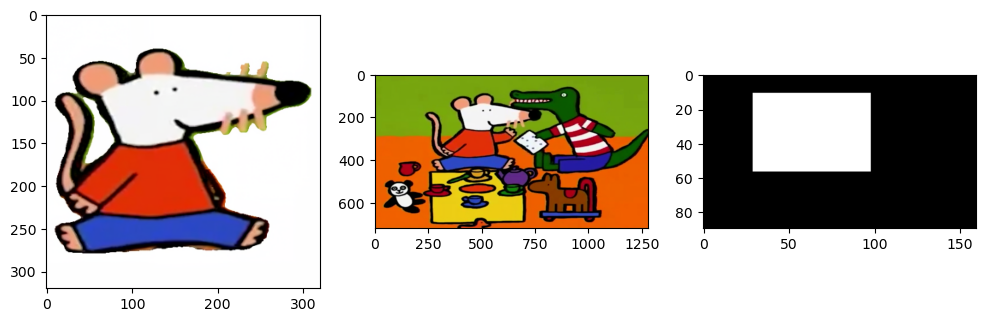

In [33]:
# possible_files = list(Path("/work/hdd/bffz/ykwon4/OpenS2V-Nexus/test3_part3_v3_cache/").glob("*_fp.safetensors"))
file = possible_files[10]

batch = load_file(str(file))

source_face_key = [k for k in batch.keys() if 'latents_clean' in k][0]
target_image_key = [k for k in batch.keys() if 'latents_' in k and k != source_face_key][0]
target_mask_key = [k for k in batch.keys() if 'target_latent_masks' in k][0]
source_face = postproc_imgs(batch[source_face_key].unsqueeze(0), vae)[0]
target_image = postproc_imgs(batch[target_image_key].unsqueeze(0), vae)[0]
target_mask = Image.fromarray(batch[target_mask_key][:,0,:,:].permute(1,2,0)[...,0].cpu().numpy() > 0)

try:
    topiq_score = iqa_metric(Image.fromarray(target_image)).item()
except AssertionError as e:
    topiq_score = 0.0
try:
    topiq_face_score = iqa_metric_face(Image.fromarray(source_face)).item()
except AssertionError as e:
    topiq_face_score = 0.0

print(topiq_score, topiq_face_score)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(source_face)
ax[1].imshow(target_image)
ax[2].imshow(target_mask, cmap='gray')
plt.show()

In [27]:
# batch = load_file("/groups/chenchen/patrick/OpenS2V-Nexus/datasets/test3_part2_v2_cache/_U_VP1ara2E_segment_19_step1-0-79_step2-0-79_step4_step5_step6_1280x0720_fp.safetensors")
# batch = load_file("/groups/chenchen/patrick/Anime-Shooter/test_output_cache/__nYnywW7fk-segment_1432_2836-shot_1432_1498_1280x0720_fp.safetensors")
possible_files = list(Path("/work/hdd/bffz/ykwon4/Anime-Shooter/test_output_chara2_cache").glob("*_fp.safetensors"))

df = []
for i, file in tqdm(enumerate(possible_files), total=len(possible_files)):
    batch = load_file(str(file))

    source_face_key = [k for k in batch.keys() if 'latents_clean' in k][0]
    target_image_key = [k for k in batch.keys() if 'latents_' in k and k != source_face_key][0]
    target_mask_key = [k for k in batch.keys() if 'target_latent_masks' in k][0]
    source_face = postproc_imgs(batch[source_face_key].unsqueeze(0), vae)[0]
    target_image = postproc_imgs(batch[target_image_key].unsqueeze(0), vae)[0]
    target_mask = Image.fromarray(batch[target_mask_key][:,0,:,:].permute(1,2,0)[...,0].cpu().numpy() > 0)

    try:
        topiq_score = iqa_metric(Image.fromarray(target_image)).item()
    except AssertionError as e:
        topiq_score = 0.0
    # try:
    #     topiq_face_score = iqa_metric_face(Image.fromarray(source_face)).item()
    # except AssertionError as e:
    #     topiq_face_score = 0.0
    df.append({
        "file": str(file.stem), 
        "topiq_score": topiq_score,
        # "topiq_face_score": topiq_face_score
    })
    if i % 10 == 0:
        pd.DataFrame(df).to_csv("Anime-Shooter_topiq_scores.csv", index=False)
        
pd.DataFrame(df).to_csv("Anime-Shooter_topiq_scores.csv", index=False)

  0%|          | 12/11075 [00:35<9:08:00,  2.97s/it]


KeyboardInterrupt: 

In [ ]:
sys.argv = ["fpack_cache_latents.py",
    "--dataset_config", "/home/ce407038/patrick/datasets/OpenS2V-Nexus/tmp.toml",
    "--vae", "~/patrick/ComfyUI/models/vae/hunyuan_video_vae_bf16.safetensors",
    "--image_encoder", "~/patrick/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors",
    "--vae_chunk_size", "32",
    "--vae_spatial_tile_sample_min_size", "128", 
    "--skip_existing", "--keep_cache", "--one_frame", "--one_frame_no_2x", "--one_frame_no_4x"
]

parser = setup_parser_common()
parser = hv_setup_parser(parser)  # VAE
# parser = framepack_setup_parser(parser)
parser.add_argument("--image_encoder", type=str, required=True)
parser.add_argument("--f1", action="store_true")
parser.add_argument("--one_frame", action="store_true")
parser.add_argument("--one_frame_no_2x", action="store_true")
parser.add_argument("--one_frame_no_4x", action="store_true")
args = parser.parse_args()

blueprint_generator = BlueprintGenerator(ConfigSanitizer())
user_config = load_user_config(args.dataset_config)
blueprint = blueprint_generator.generate(user_config, args, architecture='fp')
train_dataset_group = generate_dataset_group_by_blueprint(blueprint.dataset_group)
dataset = train_dataset_group.datasets[0]

# dataset = ImageDataset(
#     resolution=(960, 544), caption_extension='.txt', batch_size=2, num_repeats=1, 
#     enable_bucket=True, bucket_no_upscale=False, 
#     image_directory=None, 
#     image_jsonl_file=str(mpath / "OpenS2V_part1_test3_2_test_v2.jsonl"), 
#     control_directory=None,
#     cache_directory=str(mpath / "test3_2_cache_v2"), 
#     # cache_directory=None,
#     fp_latent_window_size=9, fp_1f_clean_indices=[0], fp_1f_target_index=9, 
#     fp_1f_no_post=True, debug_dataset=False, architecture='fp', 
#     control_resolution=(256,256)
# )

In [ ]:
_,batch = next(iter(dataset.retrieve_latent_cache_batches(4)))
_, _, image, contents, content_masks, target_masks, clean_latent_bboxes = preprocess_contents(batch)
print(image)
print(contents)
print(target_masks)
print(clean_latent_bboxes)

i = 0
print(Path(batch[i].item_key).parent.name)
meta_path = Path(batch[i].item_key).parent / "meta.yaml"
meta = OmegaConf.load(meta_path)
print(meta['target_body'], meta['width'], meta['height'])

bboxes = get_bbox_from_meta(meta_path, 2)
print(bboxes)

mask = target_masks[i,0].permute(1,2,0).cpu().numpy().astype(bool).max(-1)
face_bbox = clean_latent_bboxes[i,0].numpy()
draw_bboxes(Image.fromarray(mask).convert("RGB").resize((960,544)), face_bbox)

In [ ]:
with torch.no_grad():
    image = image.to(vae.device, dtype=vae.dtype)  # B, C, H, W
    contents = contents.to(vae.device, dtype=vae.dtype)  # B, C, F, H, W
    target_masks = target_masks.to(vae.device, dtype=vae.dtype)

    # VAE encode: we need to encode one frame at a time because VAE encoder has stride=4 for the time dimension except for the first frame.
    target_latent = vae_encode(image, vae).to("cpu")  # B, C, 1, H/8, W/8
    clean_latents = [vae_encode(contents[:, :, idx : idx + 1], vae).to("cpu") for idx in range(contents.shape[2])]
    clean_latents = torch.cat(clean_latents, dim=2)  # B, C, F, H/8, W/8

    # apply alphas to latents
    for b, item in enumerate(batch):
        for i, content_mask in enumerate(content_masks[b]):
            if content_mask is not None:
                # apply mask to the latents
                # print(f"Applying content mask for item {item.item_key}, frame {i}")
                clean_latents[b : b + 1, :, i : i + 1] *= content_mask

    # Vision encoding per‑item (once): use control content because it is the start image
    # images = [item.control_content[0] for item in batch]  # list of [H, W, C]
    images = [item.embed_content for item in batch]

    # encode image with image encoder
    image_embeddings = []
    with torch.no_grad():
        for image in images:
            if image.shape[-1] == 4:
                image = image[..., :3]
            image_encoder_output = hf_clip_vision_encode(image, feature_extractor, image_encoder)
            image_embeddings.append(image_encoder_output.last_hidden_state)
    image_embeddings = torch.cat(image_embeddings, dim=0)  # B, LEN, 1152
    image_embeddings = image_embeddings.to("cpu")  # Save memory

In [ ]:
dataset.set_seed(0)
dataset.prepare_for_training()
# for _, batch in tqdm(dataset.retrieve_latent_cache_batches(4)):
    # items = batch
train_dataset_group = DatasetGroup([dataset])

collator = collator_class(Value("i", 0), Value("i", 0), None)

train_dataloader = DataLoader(
    train_dataset_group,
    batch_size=1,
    shuffle=True,
    collate_fn=collator,
    num_workers=2,
    persistent_workers=True,
)

batch = next(iter(train_dataloader))
batch

In [ ]:
train_els = [json.loads(x) for x in 
    (mpath / "OpenS2V_part1_test3_2_test_v2.jsonl").read_text().split('\n')
]
for el in tqdm(train_els):
    name = Path(el['meta']).parent.name
    tmp_paths = list(mpath.glob(f'test3_2_cache_v2/{name}_*_fp.safetensors'))
    if len(tmp_paths) > 0:
        cache = load_file(tmp_paths[0])
        cache['clean_latent_indices_int64'] = torch.tensor([0], dtype=torch.int64)
        save_file(cache, tmp_paths[0])

In [ ]:
dset_path = Path("/groups/chenchen/patrick/OpenS2V-Nexus/datasets")
dset_name = "test3_2_cache_v2"
candidates = sorted([x.name.split("_fp")[0] for x in (dset_path / dset_name).glob("*_fp.safetensors")])
print(len(candidates))

list_with_bbox = []
for name in tqdm(candidates):
    control_kwargs = load_file(dset_path / f"{dset_name}/{name}_fp.safetensors")

    entity_key = [k for k in control_kwargs.keys() if "target_latent_masks_" in k][0]
    clean_key = [k for k in control_kwargs.keys() if "latents_clean_" in k][0]
    entity_mask = control_kwargs[entity_key][0].permute(1,2,0).cpu().numpy().astype(bool)[...,0]
    clean_latents = control_kwargs[clean_key]
    w, h = entity_mask.shape[1], entity_mask.shape[0]
    clean_w, clean_h = clean_latents.shape[3], clean_latents.shape[2]

    # face_bbox = [
    #     bbox[0], bbox[1], 
    #     min((bbox[0]*entity_mask.shape[1]+clean_w)/entity_mask.shape[1], 1.0),
    #     min((bbox[1]*entity_mask.shape[0]+clean_h)/entity_mask.shape[1], 1.0),
    # ]
    bbox = get_bbox_from_mask(entity_mask)
    face_bbox = get_facebbox_from_bbox(bbox, clean_w, clean_h, w, h, full_width=False)
    clean_latent_bboxes = torch.tensor([face_bbox]).float()
    control_kwargs["clean_latent_bboxes_float32"] = clean_latent_bboxes
    # draw_bboxes(Image.fromarray(entity_mask).convert("RGB").resize((960,544)), [face_bbox])
    
    # if len(control_kwargs["clean_latent_bboxes_float32"].shape) == 4:
    #     control_kwargs["clean_latent_bboxes_float32"] = control_kwargs["clean_latent_bboxes_float32"][0,0].float()
    # elif len(control_kwargs["clean_latent_bboxes_float32"].shape) == 3:
    #     control_kwargs["clean_latent_bboxes_float32"] = control_kwargs["clean_latent_bboxes_float32"][0].float()
    # elif len(control_kwargs["clean_latent_bboxes_float32"].shape) == 1:
    #     control_kwargs["clean_latent_bboxes_float32"] = control_kwargs["clean_latent_bboxes_float32"].unsqueeze(0).float()

    save_file(control_kwargs, dset_path / f"{dset_name}/{name}_fp.safetensors")
    if "clean_latent_bboxes_float32" in control_kwargs:
        list_with_bbox.append(name)
print(len(list_with_bbox))

In [ ]:
buckset_selector = BucketSelector([960, 544], True, False, "fp")

train_els = [json.loads(x) for x in 
    (mpath / "OpenS2V_part1_test3_2_test_v2.jsonl").read_text().split('\n')
]

for i, batch in enumerate(tqdm(train_els)):
    # train_els[i]['meta'] = str(Path(batch['image_path']).parent / "meta.yaml")
    name = Path(batch['meta']).parent.name
    meta = OmegaConf.load(batch['meta'])
    keys = [0]
    c_H, c_W = 256, 256

    image_size = Image.open(batch['image_path']).convert("RGB").size
    bucket_reso = buckset_selector.get_bucket_resolution(image_size)
    entity_bboxes = [meta['target_body'].get(str(x), [0.0,0.0,0.0,0.0]) for x in [keys]]
    entity_bboxes = [[x[0]/meta['width'], x[1]/meta['height'], x[2]/meta['width'], x[3]/meta['height']] for x in entity_bboxes]
    clean_latent_bboxes = torch.tensor([[bbox[0], bbox[1], bbox[0]+(c_H / bucket_reso[1]), bbox[1]+(c_W / bucket_reso[0])] for bbox in entity_bboxes]).float()

    control_cache_path = (mpath / f'test3_2_cache_v2/{name}_1280x0720_fp.safetensors')
    control_cache = load_file(control_cache_path)
    control_cache['clean_latent_bboxes_float32'] = clean_latent_bboxes
    save_file(control_cache, mpath / f'test3_2_cache_v2/{name}_1280x0720_fp.safetensors')


# (mpath / "OpenS2V_part1_test3_2_test_v2.jsonl").write_text(
#     "\n".join([json.dumps(x) for x in train_els])
# )

In [ ]:
test_els = [json.loads(x) for x in 
    (mpath / "OpenS2V_part1_test3_2_test.jsonl").read_text().split('\n')
]
samples = []
for i in [0, 10]:
    name = Path(test_els[i]['image_path']).parent.name
    batch_path = mpath / f"test3_2/{name}"
    meta = OmegaConf.load(batch_path / "meta.yaml")

    prompt = meta['cap'][0]
    control_image_path = batch_path / "source_facecrop_0.png"
    mask_path = batch_path / "target_bodymask_0.png"
    of = "--of target_index=9,control_index=0,no_2x,no_4x,no_post --d 1111 --f 1 --s 25 --w 1280 --h 720"
    sample = f"{prompt} --i {str(control_image_path.absolute())} --ci {str(control_image_path.absolute())} --em {str(mask_path.absolute())} {of}"
    samples.append(sample)

Path(mpath / "test3_2_sample_prompts.txt").write_text("\n".join(samples))

In [ ]:
# num_workers = max(1, os.cpu_count() - 1)

# all_latent_cache_paths = []
# for _, batch in tqdm(dataset.retrieve_latent_cache_batches(num_workers)):
#     filtered_batch = []
#     for item in batch:
#         if item.frame_count is None:
#             all_latent_cache_paths.append(item.latent_cache_path)
#             all_existing = os.path.exists(item.latent_cache_path)
#         else:
#             latent_f = (item.frame_count - 1) // 4 + 1
#             num_sections = max(1, math.floor((latent_f - 1) / item.fp_latent_window_size))  # min 1 section
#             all_existing = True
#             for sec in range(num_sections):
#                 p = append_section_idx_to_latent_cache_path(item.latent_cache_path, sec)
#                 all_latent_cache_paths.append(p)
#                 all_existing = all_existing and os.path.exists(p)

#         if not all_existing:  # if any section cache is missing
#             filtered_batch.append(item)

#     if len(filtered_batch) == 0:  # all sections exist
#         continue

#     encode_and_save_batch_one_frame(
#         vae, feature_extractor, image_encoder, filtered_batch, 
#         vanilla_sampling = False,
#         one_frame_no_2x = True,
#         one_frame_no_4x = True,
#     )
    
# # normalize paths
# all_latent_cache_paths = [os.path.normpath(p) for p in all_latent_cache_paths]
# all_latent_cache_paths = set(all_latent_cache_paths)

In [ ]:

# test_clean1 = [json.loads(x) for x in 
#     (mpath / "OpenS2V_part1_test3_2_train.jsonl").read_text().split('\n')
# ]
# test_clean1 = np.delete(test_clean1, errorneous)

# (mpath / "OpenS2V_part1_test3_2_test_2.jsonl").write_text(
#     "\n".join([json.dumps(x) for x in test_clean1])
# )

# control_imgs_sizes = []
# for i, test_clean in enumerate(tqdm(test_clean1)):
#     control_img_sizes = [Image.open(v).size for k,v in test_clean.items() if 'control_path' in k]
#     control_imgs_sizes.extend(control_img_sizes)
# print(np.mean([list(x) for x in control_imgs_sizes], axis=0))

# control_imgs_sizes = []
# errorneous = []
# for i, test_clean in enumerate(tqdm(test_clean1)):
#     try:
#         control_img_sizes = [Image.open(v).size for k,v in test_clean.items() if 'control_path' in k]
#         control_imgs_sizes.extend(control_img_sizes)
#     except Exception as e:
#         print(f"Error processing {test_clean['image_path']}: {e}")
#         errorneous.append(i)

# for i in erroneous:
# for test_clean in test_clean1:

# train_els = [json.loads(x) for x in 
#     (mpath / "OpenS2V_part1_test3_2_test.jsonl").read_text().split('\n')
# ]
# for i, batch in enumerate(train_els):
#     train_els[i]['meta'] = str(Path(batch['image_path']).parent / "meta.yaml")

# (mpath / "OpenS2V_part1_test3_2_test_v2.jsonl").write_text(
#     "\n".join([json.dumps(x) for x in train_els])
# )